# The PSID

Preferential Subspace Identification (PSID) is a powerful neural manifold learning method designed to model the latent dynamics of high-dimensional neural activity. It leverages system identification principles to dissociate neural dynamics that are behaviorally relevant from those that are not, offering a structured approach to separate and model distinct components of neural activity. By projecting the high-dimensional neural data into low-dimensional subspaces, PSID preferentially identifies latent states that directly contribute to specific behavioral outputs, making it an effective tool for tasks like decoding neural signals and understanding brain-behavior relationships.

PSID operates by decomposing neural data into latent variables, focusing on identifying dimensions that both capture the internal state of the system and contribute to behavioral outcomes. This method outperforms traditional linear methods by dissociating and prioritizing behaviorally relevant neural dynamics, making it a valuable tool in the study of population coding and dynamical systems modeling in neuroscience.

## Pictorial Understanding

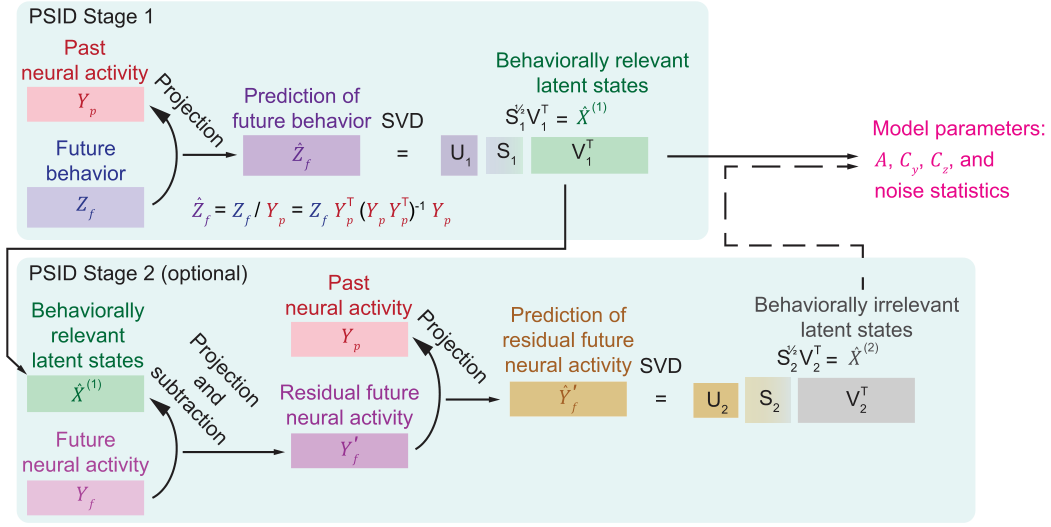

The model is based on state-space modeling and Kalman filtering principles, where the goal is to learn a dynamic system of latent states x(t)x(t) that evolve over time and relate to both neural activity Y(t)Y(t) and behavior Z(t)Z(t)

### The PSID model uses the following equations to describe the dynamics:

### Technical Overview of PSID

The model is based on state-space modeling and Kalman filtering principles.

The PSID model uses the following equations to describe the dynamics:

$$
x(t+1) = A x(t) + B u(t) + w(t)
$$
$$
Y(t) = C x(t) + D u(t) + v(t)
$$
$$
Z(t) = C_z x(t) + D_z u(t) + v_z(t)
$$

Where:
- x(t) is the latent state.
-  u(t)  represents external inputs.
-  Y(t)  is the observed neural activity.
- Z(t) is the observed behavior.
- \( A, B, C, D, C_z, D_z \) are system matrices that govern the dynamics.
- \( w(t), v(t), v_z(t) \) are noise terms.


### Usage and Installation:

In [38]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [39]:
pip install PSID --upgrade

In [40]:
import PSID

The following shows the external working of PSID- (this doesn't imply to the the System identification matrixes, for that see tha Kalman function in the original PSID code)

$$
idSys = PSID.PSID(y, z, nx, n1, i)
$$

Inputs:

    y and z are time x dimension matrices with neural (e.g. LFP signal powers or spike counts) and behavioral data (e.g. joint angles, hand position, etc), respectively.
    
    IPSID also takes u as an input, which is a time x dimension matrix, containing the measured input data.
    
    nx is the total number of latent states to be identified.
    
    n1 is the number of states that are going to be dedicated to behaviorally relevant dynamics.
    
    i is the subspace horizon used for modeling.

### Link to the database

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import configparser


config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/MLC/config.ini') ##adjust the path to config.ini
default = config['DEFAULT']
data_path = default['DataPath']

firing_rates_data = np.load(f"{data_path}firing_rates_Cori-14.npz")['data']
behavior_intervals_data = np.load(f"{data_path}behavior_intervals_Cori-14.npz")['data']
xPred = np.load(f"{data_path}PSID_2D_Cori-14_2_2_5.npz")['xPred']
xPred_17 = np.load(f"{data_path}PSID_2D_Cori-17_2_2_2.npz")['xPred']
xPred_CEBRA = np.load(f"{data_path}CEBRA_2D_Cori-14.npz")['xPred']

In [11]:
neural_data_2 = np.load(f"{data_path}firing_rates_Cori-17.npz")
firing_rates_data_2 = neural_data_2['data']
behaviour_data_2 = np.load(f"{data_path}behavior_intervals_Cori-17.npz")
behavior_intervals_data_2 = behaviour_data_2['data']

In [10]:
print(firing_rates_data.shape)
print(behavior_intervals_data.shape)

(23025, 734)
(23025,)


### setting hyperparameters and adjustment in the matrices

Reshape z if it is a 1D array:

In [45]:
if behavior_intervals_data.ndim == 1:
    behavior_intervals_data = behavior_intervals_data.reshape(-1, 1)

Passing cleaned data to PSID

In [25]:
Y = firing_rates_data  # Cleaned neural data, Primary input data matrix, allYData is firing rate.
Z = behavior_intervals_data    # Behavior data (or secondary data)

if Y.ndim == 1:
    Y = Y.reshape(-1, 1)

print("Shape of Y:", firing_rates_data.shape)  # Should be (time_samples, features)
print("Shape of Z:", behavior_intervals_data.shape)

Shape of Y: (23025, 734)
Shape of Z: (23025,)


Extracting Latent state:

In [ ]:
zPred, yPred, xPred = idSys.predict(Y)

# Analysis

## The Reconstruction Score

In time-series data, one want to avoid overfitting the latent states to specific parts of the dataset. Cross-validation, especially time-series split, ensures that the model is evaluated on different segments of the data, allowing us to understand how well the model generalizes to unseen data.

The \"TimeSeriesSplit\" function helps divide the dataset into training and test splits, providing a robust estimate of performance over time-based splits, avoiding temporal data leakage.

By calculating the training loss and validation loss (in terms of Mean Squared Error), one can monitor if the model is overfitting (performing well on training data but poorly on validation data) or underfitting (failing to capture patterns in both training and validation data). Tracking losses across folds provides a deeper understanding of how well the model performs across different segments of data.


In [48]:
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

def reconstruction_score(x, y, n_splits=5):
    """
    Computes reconstruction score using time-series cross-validation.

    Args:
        x (np.ndarray): Latent state embeddings (time x latent_dims)
        y (np.ndarray): Original data (time x features)
        n_splits (int): Number of cross-validation splits

    Returns:
        avg_score (float): Average reconstruction score (R²)
        all_scores (list): List of R² scores for each fold
    """

    # Ensuring x and y are 2D arrays
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    # TimeSeriesSplit for cross-validation (good for time-series data)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    all_r2_scores = []
    train_losses = []  # List of training losses (MSE)
    val_losses = []  # List of validation losses (MSE)

    for train_index, test_index in tscv.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit linear regression model
        lin_model = LinearRegression()
        lin_model.fit(x_train, y_train)

        # Predictions for train and test sets
        y_train_pred = lin_model.predict(x_train)
        y_test_pred = lin_model.predict(x_test)


        # Compute R² score on the test set
        r2_score = lin_model.score(x_test, y_test)  # R² score
        all_r2_scores.append(r2_score)

        # Compute training loss (MSE)
        train_loss = mean_squared_error(y_train, y_train_pred)
        train_losses.append(train_loss)

        # Compute validation loss (MSE)
        val_loss = mean_squared_error(y_test, y_test_pred)
        val_losses.append(val_loss)


    # Compute average R² score
    avg_r2_score = np.mean(all_r2_scores)

    return avg_r2_score, all_r2_scores, train_losses, val_losses




In [53]:
avg_r2_score, all_r2_scores, train_losses, val_losses = reconstruction_score(xPred_17, firing_rates_data_2)

# Print results for analysis
print(f"Average R² reconstruction score: {avg_r2_score}")
print(f"All fold R² scores: {all_r2_scores}")
print(f"Training Losses (MSE) per fold: {train_losses}")
print(f"Validation Losses (MSE) per fold: {val_losses}")

Average R² reconstruction score: -0.5565887671438841
All fold R² scores: [-0.02885412112729281, -1.4105249106426314, -0.30670177482130623, -0.5975883403627047, -0.43927468876548537]
Training Losses (MSE) per fold: [0.003847137839002608, 0.003777314478067537, 0.003818602976626822, 0.003909325573965035, 0.0040805052952498574]
Validation Losses (MSE) per fold: [0.0038281679435974653, 0.004000387458951007, 0.004265516567071107, 0.004865589386577859, 0.006128237064855033]


Now we try to plot the loss..

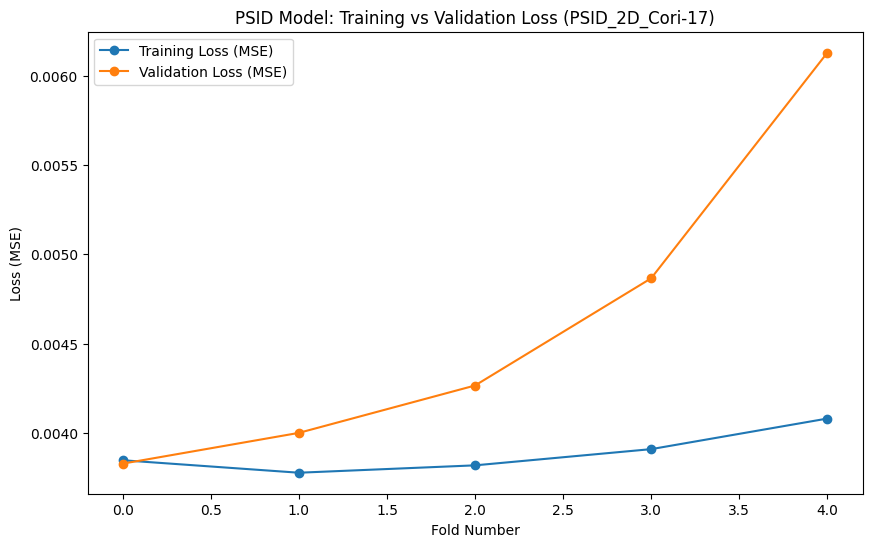

In [54]:
#Plotting training vs validation losses for each fold
def plot_loss_curves(train_losses, val_losses, title="Training vs Validation Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss (MSE)", marker='o')
    plt.plot(val_losses, label="Validation Loss (MSE)", marker='o')
    plt.xlabel("Fold Number")
    plt.ylabel("Loss (MSE)")
    plt.title(title)
    plt.legend()
    # plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, val_losses, title="PSID Model: Training vs Validation Loss (PSID_2D_Cori-17)")

This shows that in the beginning, the PSID perform quite well with the known data, but as the progress happen and the unknown data come to face, the loss also start increasing becuase of the inherent linear nature of the PSID method. With the RNN-PSID, one could overcome this incompetence in the model.

Now lets see how other method performs.

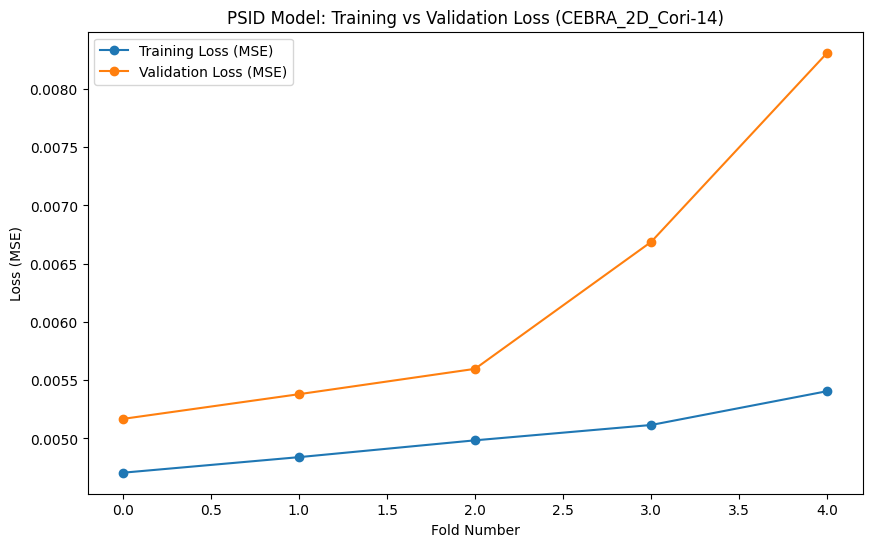

In [69]:
#Plotting training vs validation losses for each fold
def plot_loss_curves(train_losses, val_losses, title="Training vs Validation Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss (MSE)", marker='o')
    plt.plot(val_losses, label="Validation Loss (MSE)", marker='o')
    plt.xlabel("Fold Number")
    plt.ylabel("Loss (MSE)")
    plt.title(title)
    plt.legend()
    # plt.grid(True)
    plt.show()

avg_r2_score, all_r2_scores, train_losses, val_losses = reconstruction_score(xPred_CEBRA, firing_rates_data)

plot_loss_curves(train_losses, val_losses, title="PSID Model: Training vs Validation Loss (CEBRA_2D_Cori-14)")

Here, we could see that PSID on the better hyperparameter tuned data such as the past neural window facto i=2, gives better performance compare to the CEBRA with slighlty higher windows size.

## extracting intersection between infoNCE loss and Cross validation

Information Noise Contrastive Estimation is a loss function commonly used in contrastive learning. It measures how well the model can differentiate between positive (similar) and negative (dissimilar) pairs of samples.

Since, the primary goal of PSID is to extract the behaviourally relevent dynamics, the infoNCE loss is performing quite well compare to other NML methods, giving lower score (visually explained in later parts) across the 2D embedding over the reconstruction score.

In [13]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def info_nce_loss(embeddings, temperature=0.5):
    """
        Computes the InfoNCE loss for the given embeddings.

        Args:
            embeddings (torch.Tensor): Embedding vectors (batch_size x embedding_dim)
            temperature (float): Scaling factor for logits, typically between 0.1 and 1.0

        Returns:
            loss (torch.Tensor): InfoNCE loss
        """
    batch_size = embeddings.size(0)

    # Normalize the embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute similarity matrix (dot product of normalized embeddings)
    similarity_matrix = torch.matmul(embeddings, embeddings.T) / temperature

    # Create labels (positive samples are diagonal)
    labels = torch.arange(batch_size).long()

    # Compute the InfoNCE loss
    loss = F.cross_entropy(similarity_matrix, labels)

    return loss

def cross_validation_info_nce(x, n_splits=5, temperature=0.5):
    """
        Performs cross-validation to compute InfoNCE loss over multiple folds.

        Args:
            x (np.ndarray): Embedding vectors (time x latent_dims)
            n_splits (int): Number of cross-validation splits
            temperature (float): Temperature parameter for InfoNCE loss

        Returns:
            avg_loss (float): Average InfoNCE loss across folds
            fold_losses (list): List of InfoNCE losses for each fold
        """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    fold_losses = []

    for fold, (train_index, test_index) in enumerate(tscv.split(x)):
        x_train, x_test = x[train_index], x[test_index]

        # Convert to torch tensors
        x_train_torch = torch.tensor(x_train, dtype=torch.float32)
        x_test_torch = torch.tensor(x_test, dtype=torch.float32)

        # Compute InfoNCE loss for training set
        train_loss = info_nce_loss(x_train_torch, temperature=temperature)
        fold_losses.append(train_loss.item())

        print(f"Fold {fold}: InfoNCE Loss = {train_loss.item()}")

    avg_loss = np.mean(fold_losses)

    return avg_loss, fold_losses


In [27]:

avg_nce_loss, fold_losses = cross_validation_info_nce(xPred, n_splits=5, temperature=0.5)

print(f"Average InfoNCE Loss across folds: {avg_nce_loss}")

Fold 0: InfoNCE Loss = 7.476934909820557
Fold 1: InfoNCE Loss = 8.073131561279297
Fold 2: InfoNCE Loss = 8.438058853149414
Fold 3: InfoNCE Loss = 8.715668678283691
Fold 4: InfoNCE Loss = 8.938138008117676
Average InfoNCE Loss across folds: 8.328386402130127


The above code give highlights for plotting the loss over the R2 score.

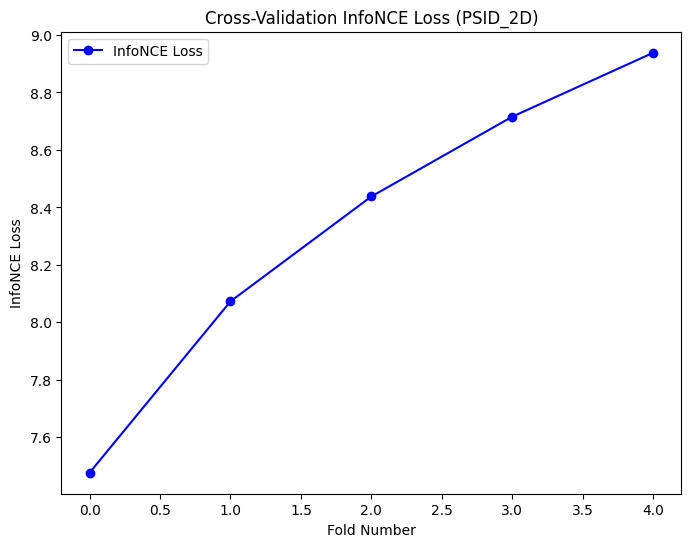

In [28]:
def plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss"):
    """
    Plots the InfoNCE loss across folds.

    Args:
        fold_losses (list): List of InfoNCE losses for each fold.
        title (str): Title for the plot.
    """

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(fold_losses)), fold_losses, marker='o', color='blue', label='InfoNCE Loss')
    plt.title(title)
    plt.xlabel('Fold Number')
    plt.ylabel('InfoNCE Loss')
    # plt.grid(True)
    plt.legend()
    plt.show()

plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss (PSID_2D)")


Now lets try to plot with the CEBRA and see if there is any difference.

Fold 0: InfoNCE Loss = 7.742517471313477
Fold 1: InfoNCE Loss = 8.338567733764648
Fold 2: InfoNCE Loss = 8.705328941345215
Fold 3: InfoNCE Loss = 8.978304862976074
Fold 4: InfoNCE Loss = 9.203152656555176


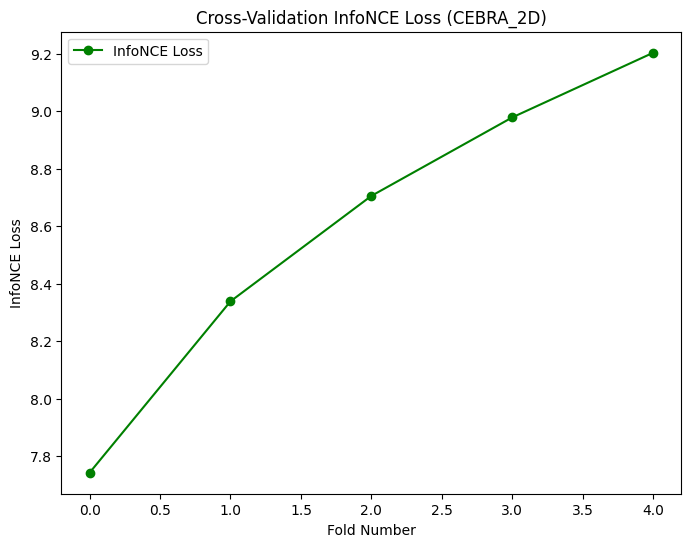

In [57]:
def plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss"):
    """
    Plots the InfoNCE loss across folds.

    Args:
        fold_losses (list): List of InfoNCE losses for each fold.
        title (str): Title for the plot.
    """

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(fold_losses)), fold_losses, marker='o', color='green', label='InfoNCE Loss')
    plt.title(title)
    plt.xlabel('Fold Number')
    plt.ylabel('InfoNCE Loss')
    # plt.grid(True)
    plt.legend()
    plt.show()


xPred_CEBRA = np.load(f"{data_path}CEBRA_2D_Cori-14.npz")['data']
avg_nce_loss, fold_losses = cross_validation_info_nce(xPred_CEBRA, n_splits=5, temperature=0.5)
plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss (CEBRA_2D)")

This suggest that PSID perform slightly batter than the CEBRA in terms of infoNCE loss even when the hyperparameters are not super tuned and any implementation of Neural network is not used. This showcase the ability of PSID to extract relevent neural dynamics.

For the purpose of analysis, we also did comparision with the BundleNet and see how it goes.

Fold 0: InfoNCE Loss = 7.955585479736328
Fold 1: InfoNCE Loss = 8.572357177734375
Fold 2: InfoNCE Loss = 8.948948860168457
Fold 3: InfoNCE Loss = 9.230093955993652
Fold 4: InfoNCE Loss = 9.461883544921875


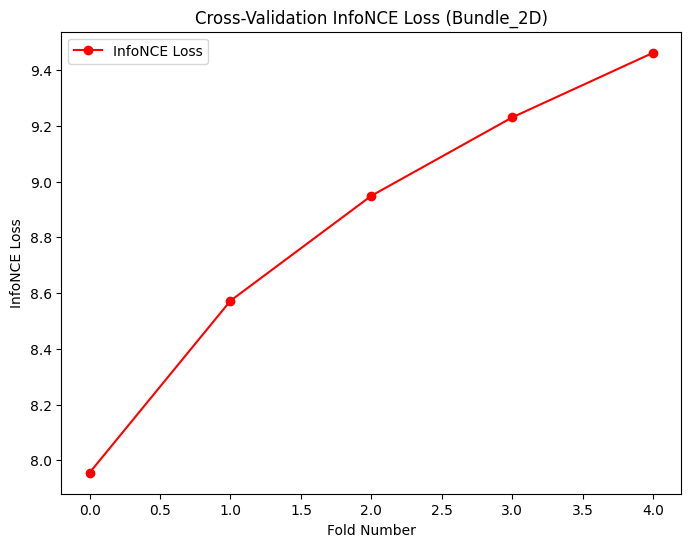

In [67]:
def plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss"):
    """
    Plots the InfoNCE loss across folds.

    Args:
        fold_losses (list): List of InfoNCE losses for each fold.
        title (str): Title for the plot.
    """

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(fold_losses)), fold_losses, marker='o', color='red', label='InfoNCE Loss')
    plt.title(title)
    plt.xlabel('Fold Number')
    plt.ylabel('InfoNCE Loss')
    # plt.grid(True)
    plt.legend()
    plt.show()

xPred_Bundle = np.loadtxt(f"{data_path}BundleNet_2D_Cori-14.unknown")

avg_nce_loss, fold_losses = cross_validation_info_nce(xPred_Bundle, n_splits=5, temperature=0.5)
plot_info_nce_loss(fold_losses, title="Cross-Validation InfoNCE Loss (Bundle_2D)")

This imply that all 3 models show sort of deteriorating performance as the cross validation progress. This also indicate that model generalizes less effectively on particular part of data.
In and all, The initial InfoNCE loss for PSID starts around 7.6, while for BundleNet, it starts around 8.0.
The final fold's InfoNCE loss for PSID reaches ~8.8, while for BundleNet, it goes higher, reaching ~9.4.
This suggests that PSID might be performing slightly better (with lower InfoNCE loss) in this cross-validation experiment compared to BundleNet and the CEBRA.


One could also combine the loss analysis for smoother understandings:

In [1]:
def combined_loss_analysis(x, y, n_splits=5, temperature=0.5):
    """
    Performs combined analysis of reconstruction and InfoNCE loss across cross-validation folds.

    Args:
        x (np.ndarray): Latent state embeddings (time x latent_dims)
        y (np.ndarray): Original data (time x features)
        n_splits (int): Number of cross-validation splits
        temperature (float): Temperature parameter for InfoNCE loss
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)

    train_losses = []
    val_losses = []
    info_nce_losses = []

    for fold, (train_index, test_index) in enumerate(tscv.split(x)):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Linear regression model for reconstruction loss
        lin_model = LinearRegression()
        lin_model.fit(x_train, y_train)
        train_loss = lin_model.score(x_train, y_train)
        val_loss = lin_model.score(x_test, y_test)

        # InfoNCE loss for embeddings
        x_train_torch = torch.tensor(x_train, dtype=torch.float32)
        nce_loss = info_nce_loss(x_train_torch, temperature=temperature)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        info_nce_losses.append(nce_loss.item())

        print(f"Fold {fold}: Train Loss = {train_loss}, Validation Loss = {val_loss}, InfoNCE Loss = {nce_loss.item()}")

    return train_losses, val_losses, info_nce_losses

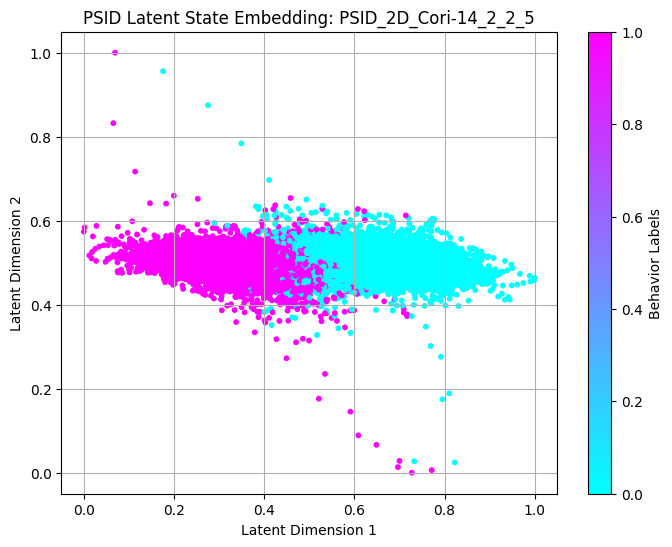

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_latent_states(xPred, behavior_intervals_data=None, title="Latent State Embedding", method_name="PSID"):

    """
    Args:
        x (np.ndarray): Latent state embeddings (time x latent_dims).
        y_labels (np.ndarray, optional): Labels for color-coding the latent states (e.g., behavior or task labels).
        title (str): Title for the plot.
        method_name (str): Name of the NML method (e.g., PSID, CEBRA) for labeling the plot.
    """

    min_length = min(xPred.shape[0], behavior_intervals_data.shape[0])
    x = xPred[:min_length]
    y_labels = behavior_intervals_data[:min_length]

    # Normalize the latent state embeddings for better visualization
    scaler = MinMaxScaler()
    xPred_scaled = scaler.fit_transform(x)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(xPred_scaled[:, 0], xPred_scaled[:, 1], c=y_labels, cmap='cool', s=10)
    plt.colorbar(scatter, label='Behavior Labels' if y_labels is not None else 'Time Points')
    plt.title(f"{method_name} Latent State Embedding: {title}")
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

    plt.grid(True)
    plt.show()

plot_latent_states(xPred, behavior_intervals_data=behavior_intervals_data, title="PSID_2D_Cori-14_2_2_5", method_name="PSID")


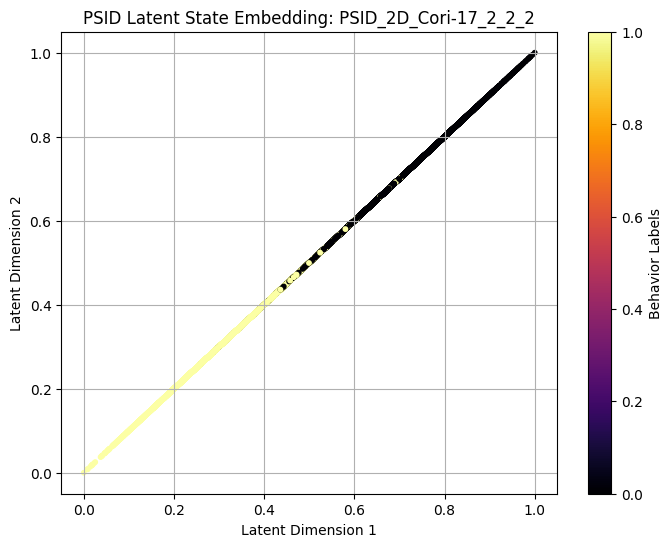

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_latent_states(xPred, behavior_intervals_data=None, title="Latent State Embedding", method_name="PSID"):

    """
    Args:
        x (np.ndarray): Latent state embeddings (time x latent_dims).
        y_labels (np.ndarray, optional): Labels for color-coding the latent states (e.g., behavior or task labels).
        title (str): Title for the plot.
        method_name (str): Name of the NML method (e.g., PSID, CEBRA) for labeling the plot.
    """

    min_length = min(xPred.shape[0], behavior_intervals_data.shape[0])
    x = xPred[:min_length]
    y_labels = behavior_intervals_data[:min_length]

    # Normalize the latent state embeddings for better visualization
    scaler = MinMaxScaler()
    xPred_scaled = scaler.fit_transform(x)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(xPred_scaled[:, 0], xPred_scaled[:, 1], c=y_labels, cmap='inferno', s=10)
    plt.colorbar(scatter, label='Behavior Labels' if y_labels is not None else 'Time Points')
    plt.title(f"{method_name} Latent State Embedding: {title}")
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')

    plt.grid(True)
    plt.show()



# xPred = xPred_17['xPred']  # Accessing the latent state embedding array

# Load behavior/task labels (if available)
behaviour_data_2 = np.load(f"{data_path}behavior_intervals_Cori-17.npz")
behavior_intervals_data_2 = behaviour_data_2['data']


plot_latent_states(xPred_17, behavior_intervals_data=behavior_intervals_data_2, title="PSID_2D_Cori-17_2_2_2", method_name="PSID")

Thus, we can come to conclusion that for the fine tuned hyperparameters like Cori-17 , where the nx, n1, and i have smaller value of 2, the plotting look much more refined.

# Conclusion

We show that the analysis with linear PSID compared with the non-linear NML methods such as CEBRA and BundleNet, still showcashed, on some factor better performace matrics.

We recognized that PSID hyperparamter tuning require better CPU to perform locally if one doesn't wish to purusue system level matrices or to hone the Kalman filter with its mathamatical setting. Without better CPU, the PSID hyperparameter tunign on 5D and 10D data doesn't get aquired.

The past neural data windows 'i', upon which the prediction factor matter, turn out following:
That with lower value of low dimension, it is recommended to pursue lower value of i such as 2 or 3. At least on the 2D and 3D data
While pursuing 5D and 10D data, where the traidional PSID (not the RNN PSID compulsory), is generally documented to perform better on the predicion side, demnad to take slightly higher value of i such as i=5, or i=10.

In order to pursue **Behaviourally Irrelevant data**, in order to get the overall neural dynamics, the RNN-PSID can be performed with its stage 2 architecture. The tradional PSID only focuses on the Stage 1 architecture, where the current focus- for the purpose of analysis and the scope of the project- was only on the **Behaviourally Relevant** data.